In [342]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

sns.set()
np.random.seed(42)

## Introduction

The aim of this project is to attempt to predict the __IMDB Rating__ of (already aired) Game of Thrones episodes based on other features of the episodes, which will be detailed in the next sections.




## Importing data

The data comes from an .xlsx file containing 73 rows, one for each episode in season 1-8. 
The columns include information on the Director, Writers, the Runtime, and the amount of Imdb votes. There is of course also a column for the target variable *Imdb Rating*. There is also a categorical information - *Major Battle* which is 1 when the episode contains one or more important battles. This value, along with the Notable Death Count, is necessarily subjective.


In [343]:
got = pd.read_excel("got_clean.xlsx", index_col = "Episode #").drop("Rotten Rating",axis = 1)
got.info()
got.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 1 to 73
Data columns (total 10 columns):
Season                 73 non-null int64
Number in Season       73 non-null int64
Major Battle           73 non-null int64
Episode Name           73 non-null object
Director               73 non-null object
Writer                 73 non-null object
Runtime (mins)         73 non-null int64
IMDB votes             73 non-null int64
Imdb Rating            73 non-null float64
Notable Death Count    73 non-null int64
dtypes: float64(1), int64(6), object(3)
memory usage: 6.3+ KB


,Season,Number in Season,Major Battle,Episode Name,Director,Writer,Runtime (mins),IMDB votes,Imdb Rating,Notable Death Count
Episode #,,,,,,,,,,
1,1,1,0,Winter Is Coming,Tim Van Patten,Benioff & Weiss,62,27685,9.0,4
2,1,2,0,The Kingsroad,Tim Van Patten,Benioff & Weiss,56,21256,8.8,3
3,1,3,0,Lord Snow,Brian Kirk,Benioff & Weiss,58,20090,8.7,0
4,1,4,0,"Cripples, Bastards, and Broken Things",Brian Kirk,Bryan Cogman,56,19123,8.8,1
5,1,5,0,The Wolf and the Lion,Brian Kirk,Benioff & Weiss,55,20062,9.1,5


## Data exploration

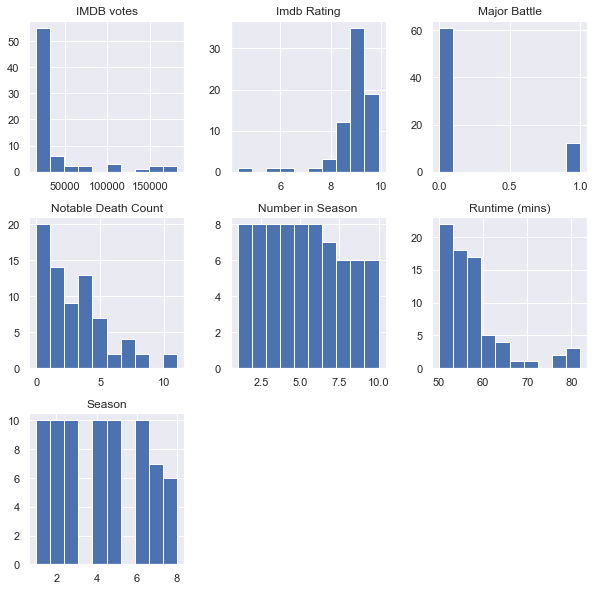

In [344]:
got.hist(figsize = (10,10))
plt.show()

Text(0.5, 1.0, 'Average IMDB  rating by season')

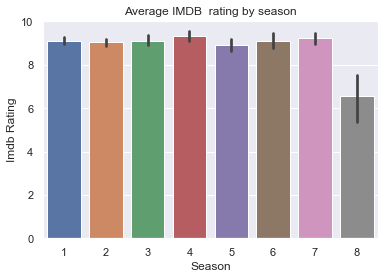

In [345]:
# Average IMDB  rating by season
sns.barplot(x = "Season", y = "Imdb Rating", data  = got)
plt.title('Average IMDB  rating by season')

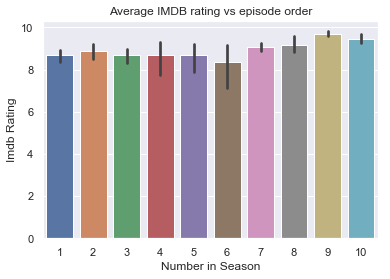

In [346]:
plt.title('Average IMDB rating vs episode order')
sns.barplot(data = got, x = "Number in Season", y= "Imdb Rating")

(3.5, 10)

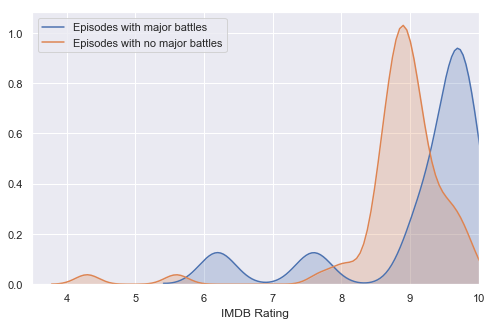

In [347]:
# Battles
plt.figure(figsize= (8,5))

got_battle = got.loc[got['Major Battle'] == 1]
got_nobattle =  got.loc[got['Major Battle'] == 0]
sns.kdeplot(got_battle['Imdb Rating'] ,label = "Episodes with major battles", shade = True)
sns.kdeplot(got_nobattle['Imdb Rating'], label = "Episodes with no major battles", shade = True)
plt.xlabel("IMDB Rating")
plt.xlim(3.5,10)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

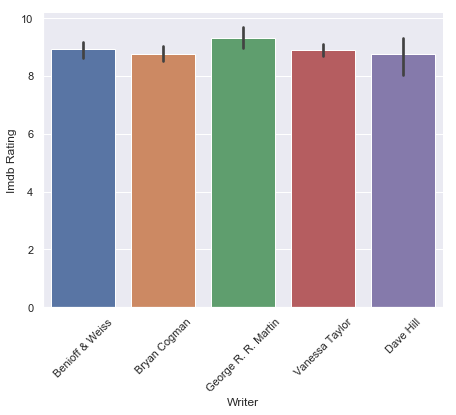

In [348]:
#writers
sns.catplot(x = "Writer", data = got, y ="Imdb Rating",  kind="bar", aspect = 1.3)
plt.xticks(rotation=45)

### New feature for Season 8

Since ratings for season 8 are much different compared to the consistently high ratings of other seasons, it might be useful to add a categorical variable __IsSeason8__ to distinguish between episodes from season 8 and all the others.

We will see later if this feature is more or less useful for the model than the original "Season" fetaure.

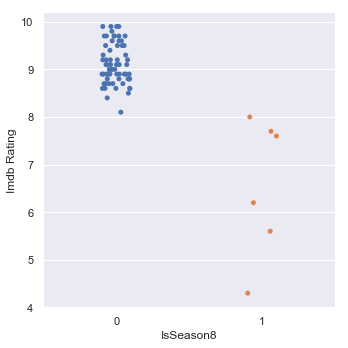

In [349]:
got['IsSeason8'] = np.where(got['Season'] == 8, '1', '0')

sns.catplot(data = got, x = "IsSeason8", y = "Imdb Rating", legend = True)

## Model preparation

In [350]:
# Inspect correlation between target and features
got.corr()['Imdb Rating']

Season                -0.394965
Number in Season       0.285181
Major Battle           0.127918
Runtime (mins)        -0.521255
IMDB votes            -0.535670
Imdb Rating            1.000000
Notable Death Count    0.186765
Name: Imdb Rating, dtype: float64

### Splitting test and training data

In [351]:
from sklearn.model_selection import train_test_split

all_features = ["Major Battle", "Season", "IsSeason8", "Runtime (mins)", "Number in Season", "Notable Death Count"]
x = got[all_features]
y = got['Imdb Rating']

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25)

## Model # 1: Decision Tree Regressor

This a model builds a progressively larger decision tree, splitting the data in subsets (the branches of the tree) that can be reached based on some conditions.
The last node of each branch is called a leaf, and it is reached when a certain condition is reached (for example, we can tell to stop at a certain __depth__ - the length of the path between a root and a leaf)

To choose the best way to split the data, it computes a cost function for each of the possible splits and then chooses the one with the lowest cost. The splitting process can be finetuned by setting some of the parameters of the model, but for now we will stick with the default and worry about parameters later.

### Feature selection with RFE

RFE stands for *Recursive Feature elimination*. It's feature selection method that starts by fitting the model with all features, and than progressively removes the weaker ones until the desired number of features is reached.

RFE can also be implemented with cross validation. That means that the dataset is split in K different "folds" and the score for each set of features is computed on every fold, and then averaged.

In [352]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

rfecv = RFECV(estimator=tree_reg, step=1, cv=3)

rfecv = rfecv.fit(xTrain, yTrain)
print(rfecv.support_)



[ True  True False  True  True  True]


Text(0.5, 1.0, 'RFECV Scores')

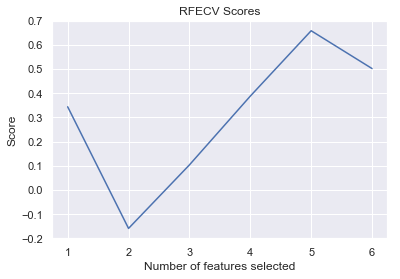

In [353]:
plt.xlabel("Number of features selected")
plt.ylabel("Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("RFECV Scores")

In [354]:
# I only select the three features recommended by the RFE
features_tree = [x for x, y in zip(all_features, rfecv.support_) if y]
print("CHOSEN FEATURES:")
print(features_tree)

xTrain_tree = xTrain[features_tree]
xTest_tree = xTest[features_tree]


CHOSEN FEATURES:
['Major Battle', 'Season', 'Runtime (mins)', 'Number in Season', 'Notable Death Count']


### Decision Tree Regressor

Now it's time to fit the model on the training set and measure how well it performs (still on the training set).
The metric I've chosen is the __RMSE__ - Root Mean Squared Error.

In [355]:
tree_reg.fit(xTrain_tree, yTrain)

tree_predictions = tree_reg.predict(xTrain_tree)
print(f'RMSE with Decision Tree Regressor: {np.sqrt(mean_squared_error(yTrain, tree_predictions))}')

RMSE with Decision Tree Regressor: 0.0


The Decision Tree Regressor seems to have 0 error! But that's likely because it is overfitting the training set. We will have to check the "real" RMSE by using cross-validation in the next sections.

## Model # 2: Random Forest Regressor

Compared to a Decision tree regressor, the Random Forest compensates for overfitting by fitting a multitude of decision trees on different sub-samples of the dataset and then averaging between them. Random decision forests correct for decision trees' habit of __overfitting__ to their training set.

Indeed, the decision tree we fitted earlier reached 0 error, which means it was very likely overfitting.

### Feature selection

The model itself can be used for feature selection because it can output the *relative importance* of the features.

In [356]:
from sklearn.ensemble import RandomForestRegressor

rnd_clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rnd_clf.fit(xTrain, yTrain)
for name, score in zip(xTrain, rnd_clf.feature_importances_):
    print(name, score)

Major Battle 0.05486690498401799
Season 0.24892098728634676
IsSeason8 0.29497181066698
Runtime (mins) 0.20574099890010367
Number in Season 0.1568421332406219
Notable Death Count 0.03865716492192957


In [357]:
# The best 3 features for this model are 
# Seson, IsSeason8 and Runtime

features_rnd = ["Season", "IsSeason8", "Runtime (mins)", "Number in Season"]
xTrain_rnd = xTrain[features_rnd]
xTest_rnd = xTest[features_rnd]

### Random Forest Regressor


In [358]:
from sklearn.metrics import mean_squared_error, r2_score

rforest_reg = RandomForestRegressor(n_estimators = 100)
rforest_reg.fit(xTrain_rnd, yTrain)

rforest_predictions = rforest_reg.predict(xTrain_rnd)
print(f'RMSE with Random Forest Regressor: {np.sqrt(mean_squared_error(yTrain, rforest_predictions))}')


RMSE with Random Forest Regressor: 0.250443754312368


## Cross-validation

On a first impression, it would seem that the Decision Tree Regressor is the best model. However, there is always a risk that the model is *overfitting* the training data.

Cross-validation is a way to check if this is happening. During cross validation, the training dataset is split again in a number K of different ways (called *folds*). 
Then the model is trained and evaluated on each of the K folds, and the mean and variance of the performance scores can be used to make a better decision on which model to choose.


In [359]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

from sklearn.model_selection import cross_val_score, KFold

In [360]:
# Decision Tree
tree_scores = cross_val_score(tree_reg, xTrain_tree, yTrain, scoring="neg_mean_squared_error",
                              cv= KFold(4, shuffle=True))

tree_rmse_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_scores)

Scores: [1.49068536 1.05931245 0.6306285  0.5144078 ]
Mean: 0.9237585281060847
Standard deviation: 0.3851214527907164


In [361]:
# Random Forest
forest_scores = cross_val_score(rforest_reg, xTrain_rnd, yTrain, scoring="neg_mean_squared_error",
                              cv= KFold(4, shuffle=True))

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [1.45515458 0.4536439  0.63296075 0.64791482]
Mean: 0.7974185119467767
Standard deviation: 0.3873614052640095


The perfomance of both models has worsened, as expected, and the now the __Random Forest__ regressor outperforms the Decision Tree. Let's see if we can finetune it and increase the performance some more.

In [362]:
xTrain = xTrain_rnd
xTest = xTest_rnd

## Model tuning

Each machine learning has a set of parameters that can either have default values, or have to be set by the user. Choosing the right value for these parameters can influence a lot the performance of the model, but it can be difficult to find these values.

sklearn offers *GridSearchCV* (CV stands for cross-validation) to find the best combination of parameters from a list of possible values. To find the combination, it also uses cross-validation to evaluate how the model performs on different subset of the training data.

In [371]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[5,20,50,100], 'max_features': [2, 3, 4], "max_depth": [5, 10, 20, None]}

grid_search = GridSearchCV(rforest_reg, param_grid, cv= KFold(4, shuffle=True),
                           scoring='neg_mean_squared_error')
    
grid_search.fit(xTrain, yTrain)    
grid_search.best_params_

C:\Users\Carolina\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': None, 'max_features': 2, 'n_estimators': 5}

In [372]:
forest_reg_new = RandomForestRegressor(n_estimators = 5, max_features = 2)
forest_reg_new.fit(xTrain, yTrain)
forest_scores = cross_val_score(forest_reg_new, xTrain, yTrain, scoring="neg_mean_squared_error",
                              cv= KFold(4, shuffle=True))

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [0.68343669 0.55198344 0.55258832 0.76188027]
Mean: 0.63747217768099
Standard deviation: 0.08958753249956018


The previous RMSE was higher than this, so that's good. Now, however, we have to test the model on the test set, which we haven't touched until now.

## Evaluating the model

We can now compute the RMSE that the model gets when trying to predict the IMDB Rating on the test dataset. To get a better estimate of the error,

In [373]:
predictions =  forest_reg_new.predict(xTest)
print('Performance on test set using Random Forest Regressor:')
print(f'RMSE: {np.sqrt(mean_squared_error(yTest, predictions))}')


from scipy import stats
confidence = 0.95
squared_errors = (predictions - yTest) ** 2
interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(),
                                    scale=stats.sem(squared_errors)))

print(f'Confidence interval: {interval}')

Performance on test set using Random Forest Regressor:
RMSE: 0.44610595861946234
Confidence interval: [0.23629406 0.58496681]


The error is higher than the one of the training set, but it's still acceptable.

In [374]:
print('PREDICTION\tREAL RATING')
for x,y in zip(predictions,yTest.values):
    print(f'{x:.3}\t\t{y}')

PREDICTION	REAL RATING
9.34		9.9
8.7		8.8
9.22		9.3
9.42		9.0
8.92		8.6
8.86		8.9
8.86		8.6
9.12		9.1
9.32		8.9
9.34		9.2
9.2		9.2
9.42		8.7
9.14		8.1
8.62		9.5
9.14		9.7
9.28		9.5
8.82		8.8
8.9		8.5
9.1		9.0
